# Face detection with cv2
## Resources
Most code in this notebook is from [real python](https://realpython.com/blog/python/face-recognition-with-python/)

Get [image shape](https://stackoverflow.com/questions/19098104/python-opencv2-cv2-wrapper-get-image-size) and [resize image](https://stackoverflow.com/questions/4195453/how-to-resize-an-image-with-opencv2-0-and-python2-6) with cv2

In [1]:
import sys
import cv2
import operator
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lxml import html
import requests

import time
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
page = requests.get('http://www.listal.com/list/most-iconic-images-cinema-history')
tree = html.fromstring(page.content)
stills = tree.xpath("//div[@class='text listnote']/a/img/@src")

In [3]:
_url_em = 'https://api.projectoxford.ai/emotion/v1.0/recognize'
_key_em = "" #Here you have to paste your primary key
_maxNumRetries = 10

In [4]:
def processRequest( json, data, headers ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url_em, json = json, data = data, headers = headers, params = None )
        print(response)

        if response.status_code == 429: 

            print("Message: %s" % ( response.json()['error']['message'] ))

            if retries <= _maxNumRetries: 
                time.sleep(5) 
                retries += 1
                continue
            else: 
                print('Error: failed after retrying!')
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None
                    #print(result) #prints all emotion dimensions
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print("Error code: %d" % ( response.status_code ))
            print("Message: %s" % ( response.json()['error']['message'] ))

        break
        
    return result

In [5]:
def renderResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""
    
    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = 5 )


    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        currEmotion = max(currFace['scores'].items(), key=operator.itemgetter(1))[0]


        textToWrite = "%s" % ( currEmotion )
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1 )

In [20]:
def from_url_analysis(url_path, out_file=None):

    urlImage =url_path
    headers =dict()
    headers['Ocp-Apim-Subscription-Key'] = _key_em
    headers['Content-Type'] = 'application/json' 
    
    json = { 'url': urlImage } 
    data = None

    result = processRequest( json, data, headers )
    
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )
    
    plt.style.use(['ggplot'])
    
    faces=pd.DataFrame()
    i=1
    
    for face in result:
        name ="Face "+ str(i)
        faces[name]=face['scores'].values()
        i=i+1
    
    if faces.shape[0] >0:
        
        fig, (ax_l, ax_r) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        ax_l.imshow( img )
        faces.plot(kind='bar', ax=ax_r).set_xticklabels(result[0]['scores'].keys())
        
        if out_file:
            
            file="./output/"+out_file+".jpg"
            
            plt.savefig(file)


<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [429]>
Message: Rate limit is exceeded. Try again later.
<Response [429]>
Message: Rate limit is exceeded. Try again later.
<Response [429]>
Message: Rate limit is exceeded. Try again later.
<Response [429]>
Message: Rate limit is exceeded. Try again later.
<Response [429]>
Message: Rate limit is exceeded. Try again later.
<Response [429]>
Message: Rate limit is exceeded. Try again later.
<Response [429]>
Message: Rate limit is exceeded. Try again later.
<Response [429]>
Message: Rate limit is exceeded. Try again later.
<Response [429]>
Message: Rate limit is exceeded. Try again later.
<Response [429]>
Message: Rate limit is exceeded. Try aga

/home/catch22/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Response [400]>
Error code: 400
Message: Failed to download the image from the URL.
nope
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [429]>
Message: Rate limit is exceeded. Try again later.
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


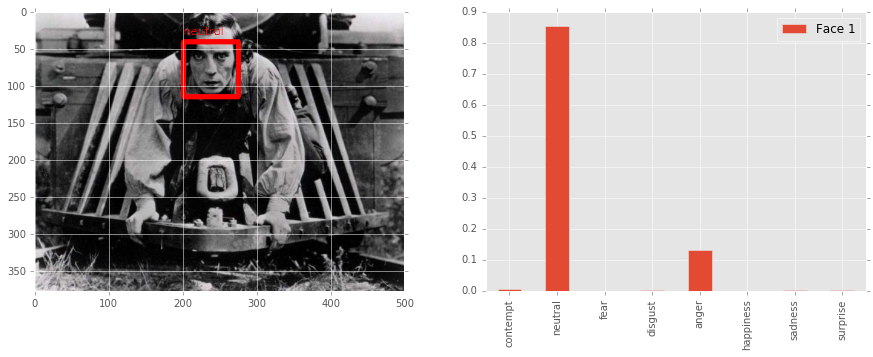

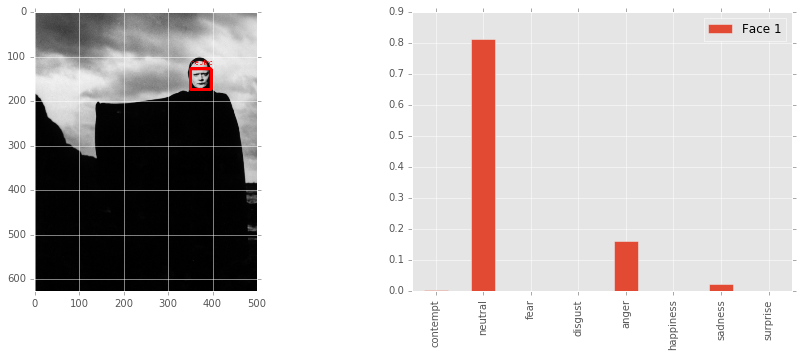

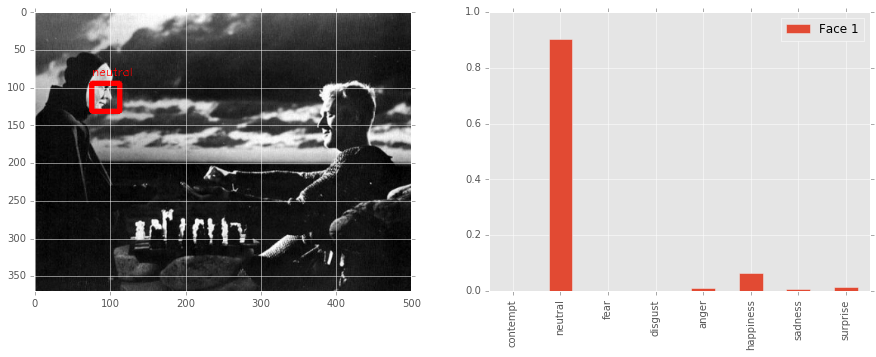

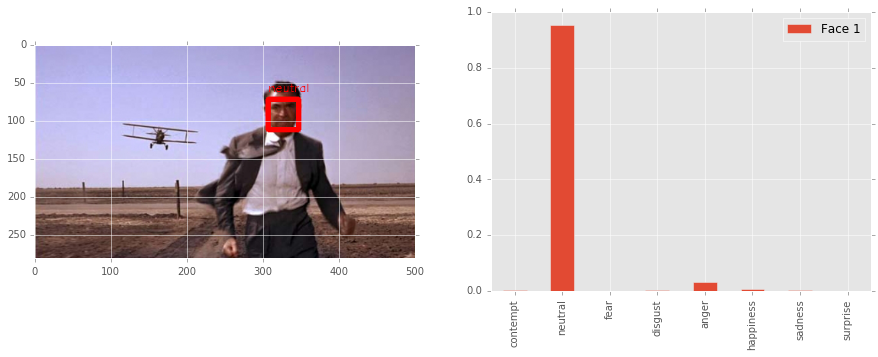

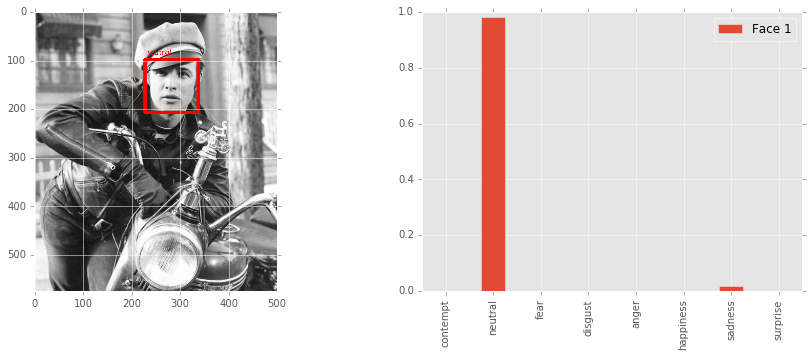

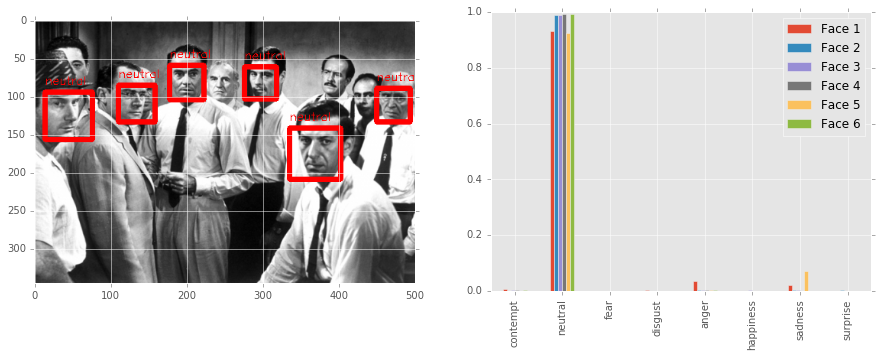

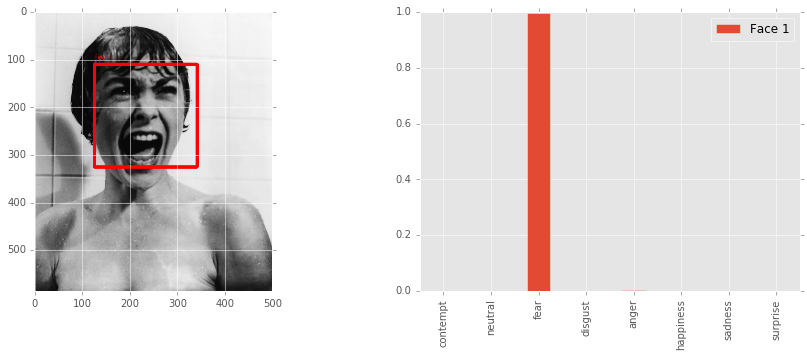

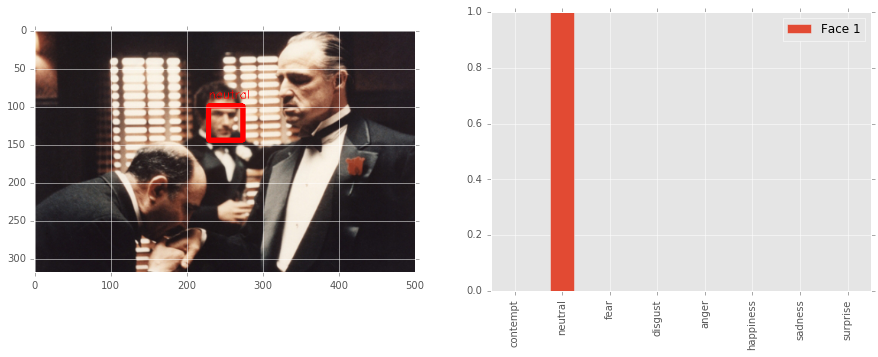

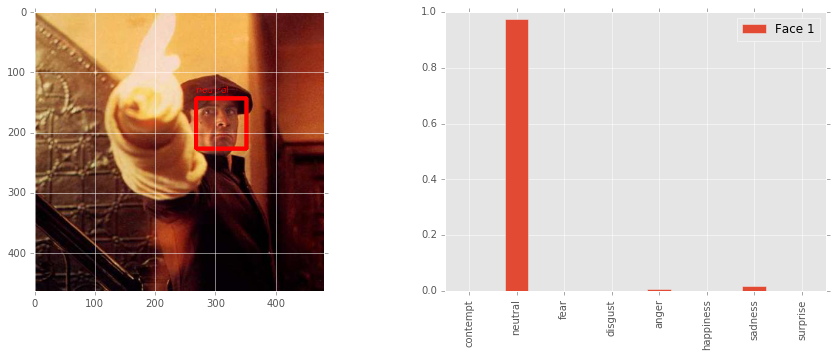

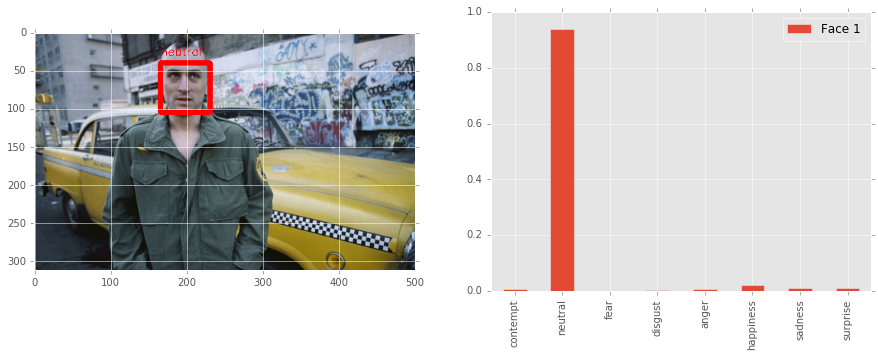

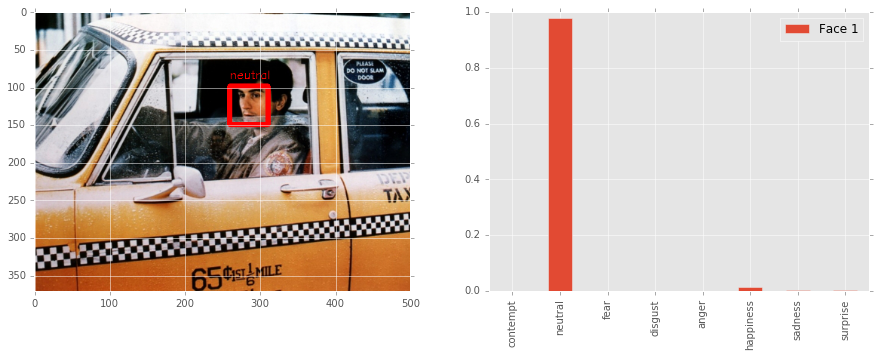

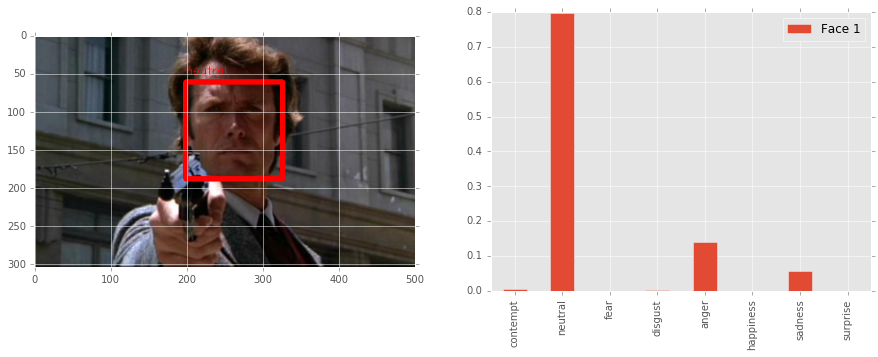

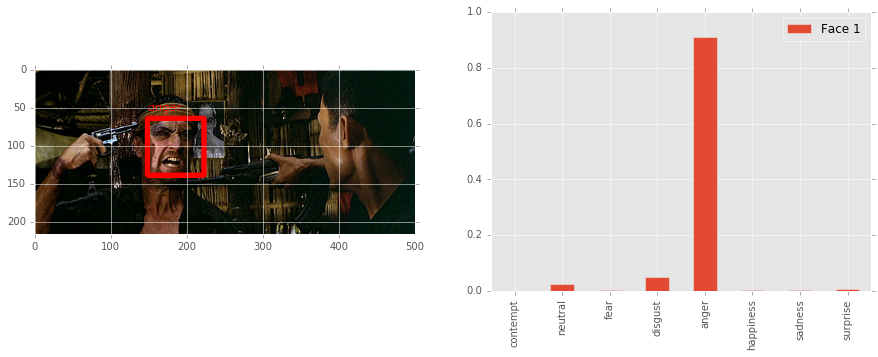

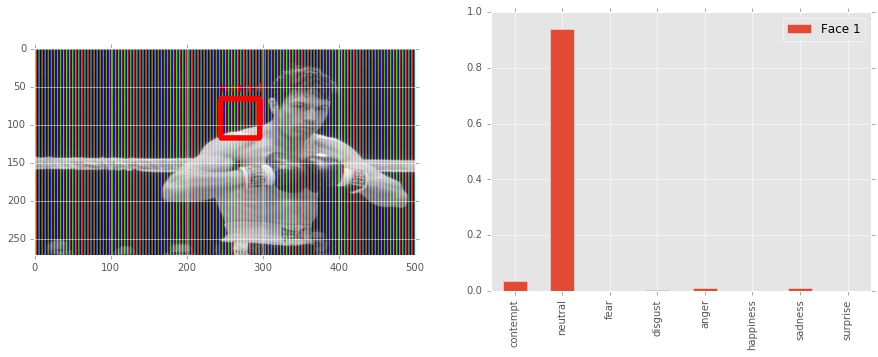

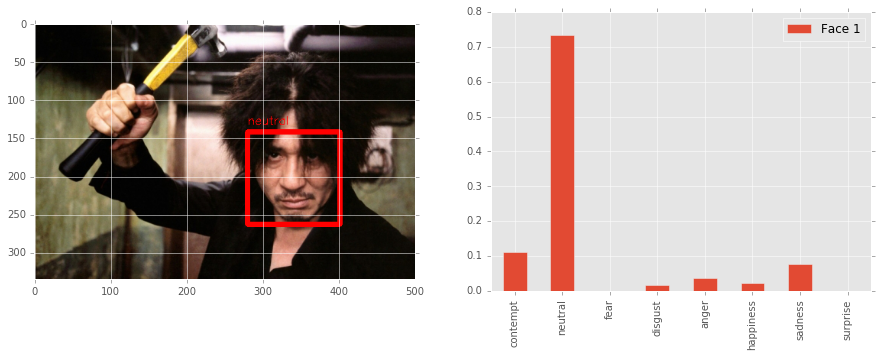

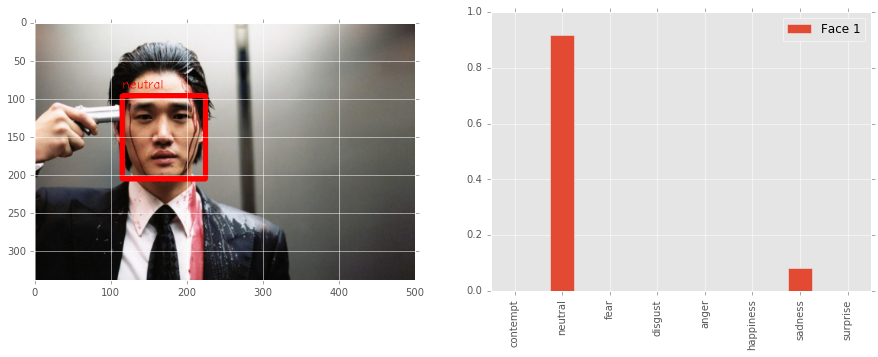

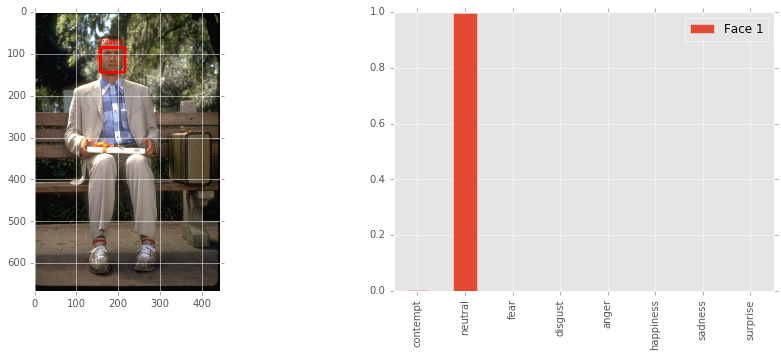

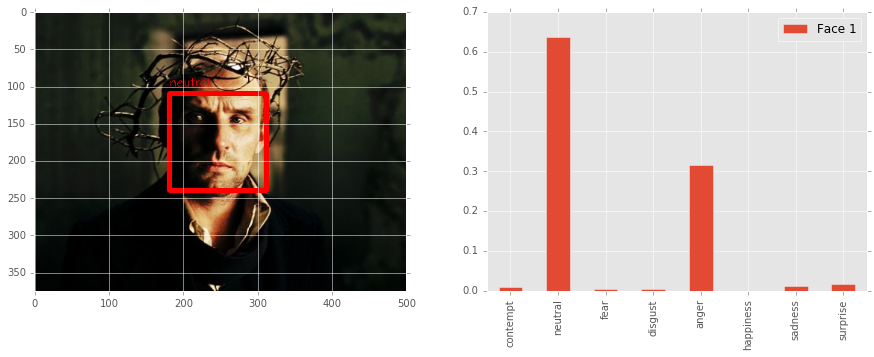

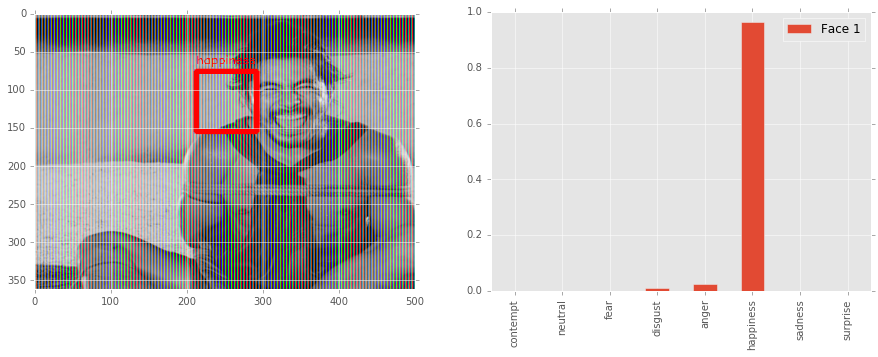

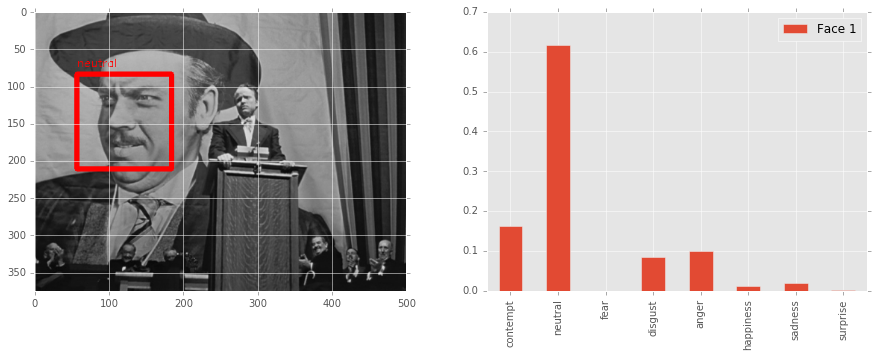

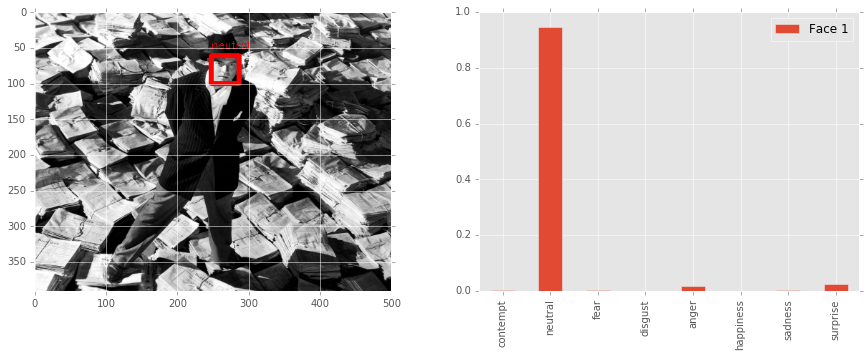

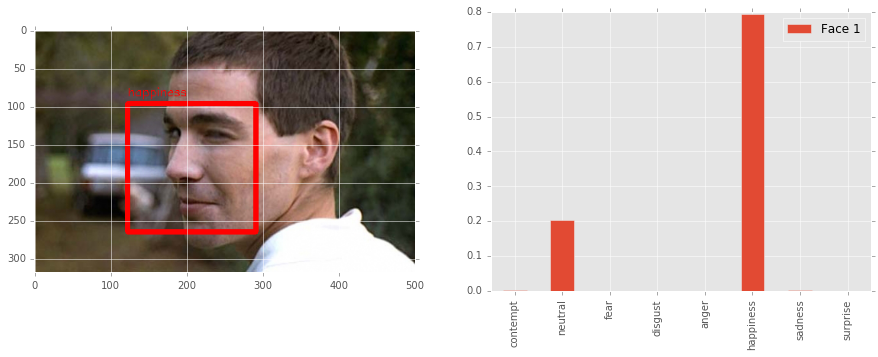

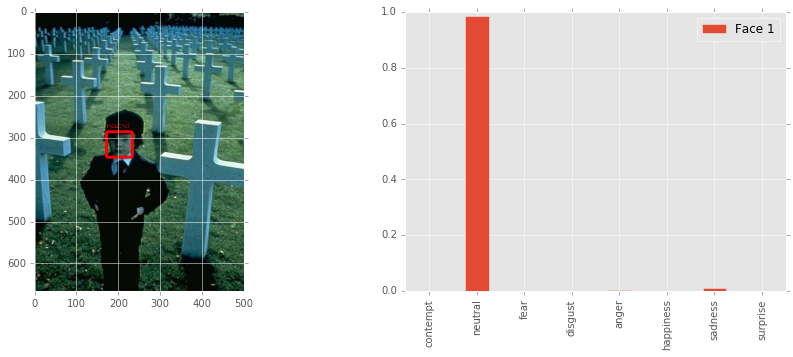

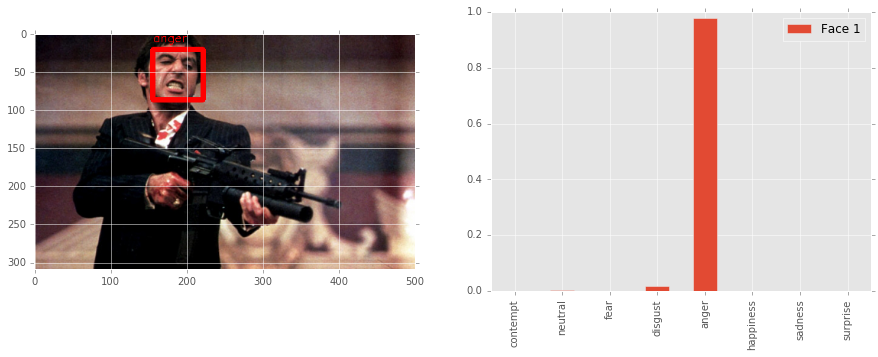

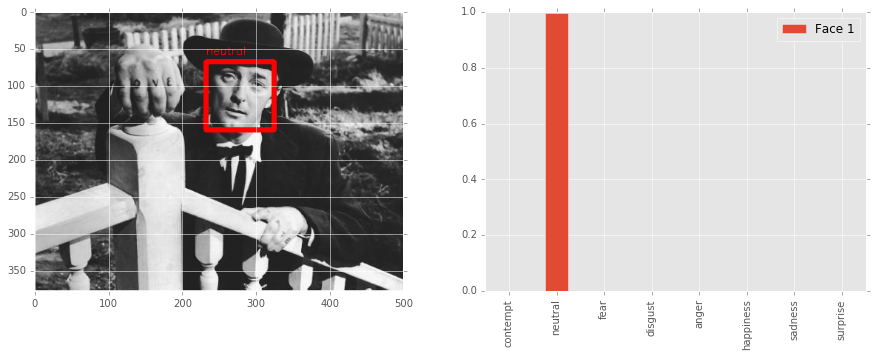

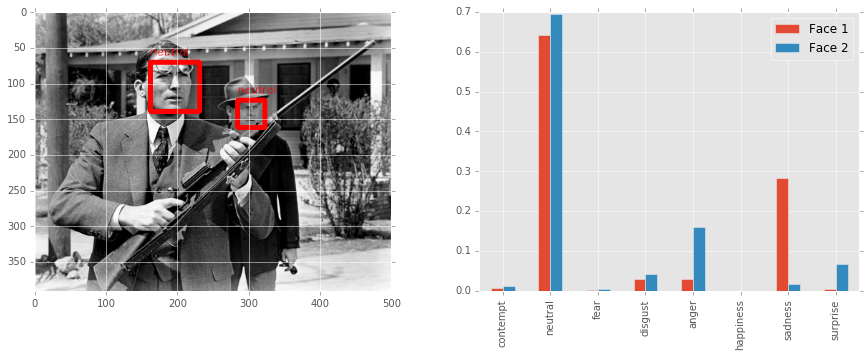

In [21]:
for i, still in enumerate(stills):
    
    try:
        
        name="still-"+str(i)
        from_url_analysis(still, out_file=name )
    
    except:
        
        print("nope")